<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment1/MLAssignment1KerrasUnbalancedData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries & read in file

In [57]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [58]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('bank-additional-full.csv', sep=';', delimiter=None, header='infer', names=None, index_col=None)

Saving bank-additional-full.csv to bank-additional-full (2).csv


# Data Exploration

(41188, 21)
No claim 36548
Claim 4640
Claim proportion 11.27%


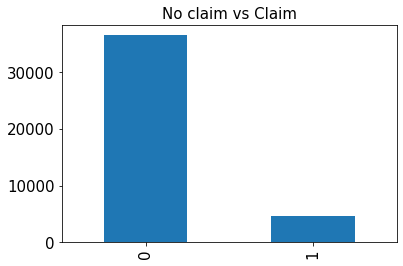

In [59]:
print(df.shape)
df.columns

def percentage(part, whole):
  return 100 * float(part) / float(whole)

df.rename(columns = {'y':'target'}, inplace = True)
df['target'] = df.target.apply(lambda x: 1 if x == "yes" else 0)

no_claim, claim = df.target.value_counts()
print(f'No claim {no_claim}')
print(f'Claim {claim}')
print(f'Claim proportion {round(percentage(claim, claim + no_claim), 2)}%')

df.target.value_counts().plot(kind="bar", title="No claim vs Claim");

## Data preprocessing

In [60]:
row_count = df.shape[0]

for c in df.columns:
  m_count = df[df[c] == -1][c].count()
  if m_count > 0:    
    print(f'{c} - {m_count} ({round(percentage(m_count, row_count), 3)}%) rows missing')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

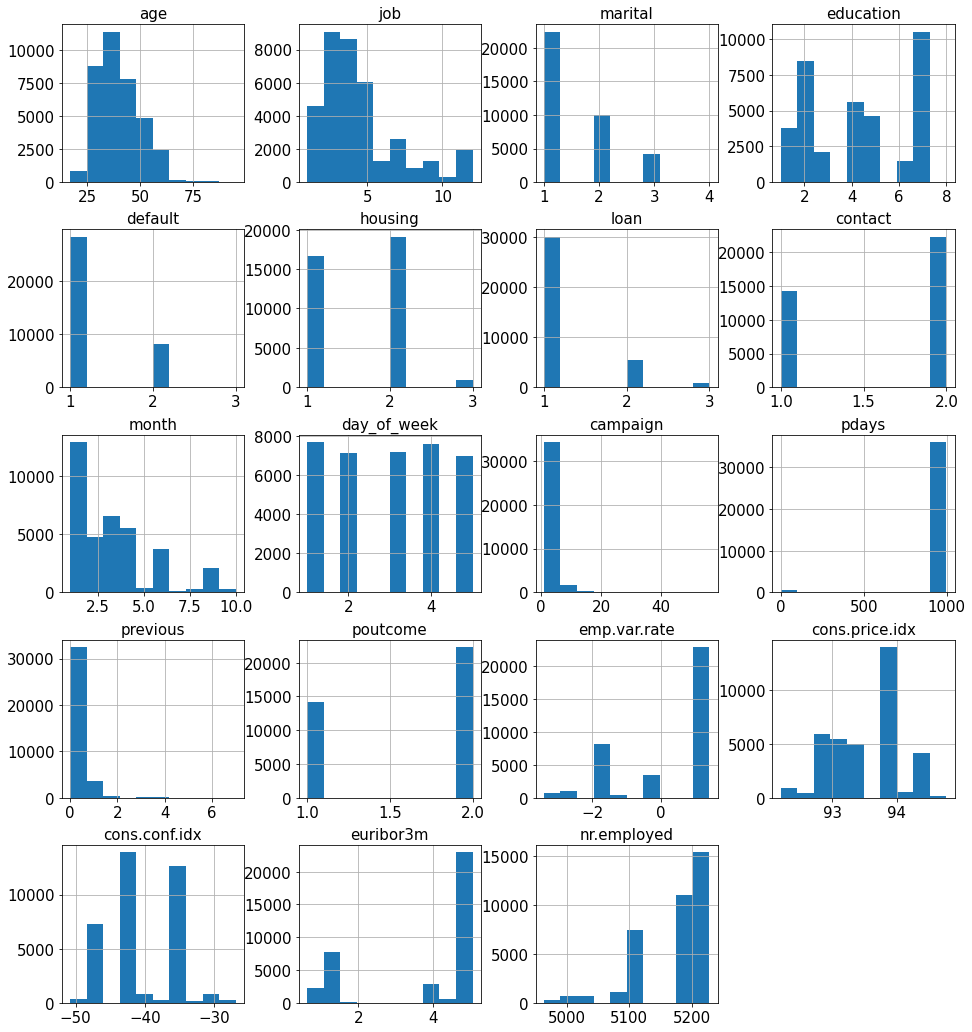

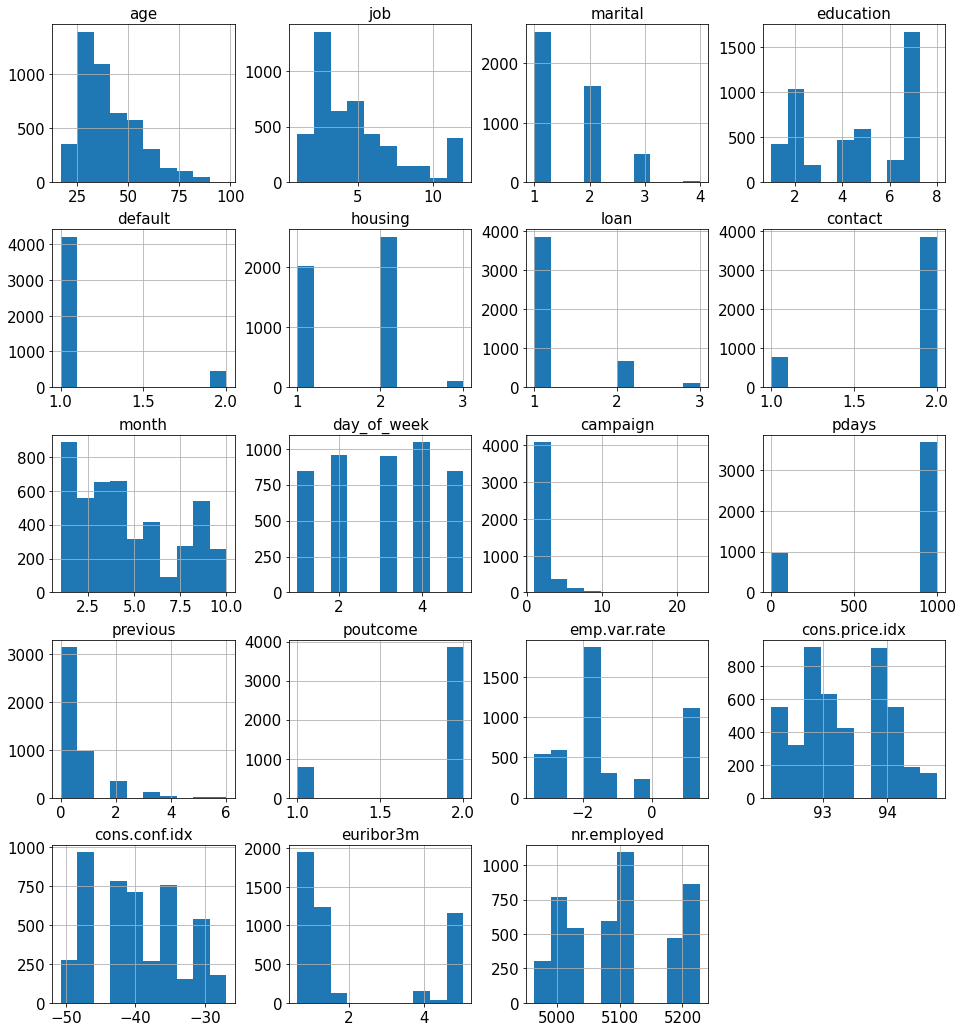

In [61]:
df.info()

df['job'] = pd.factorize(df['job'])[0] + 1
df['marital'] = pd.factorize(df['marital'])[0] + 1
df['education'] = pd.factorize(df['education'])[0] + 1
df['default'] = pd.factorize(df['default'])[0] + 1
df['housing'] = pd.factorize(df['housing'])[0] + 1
df['default'] = pd.factorize(df['default'])[0] + 1
df['loan'] = pd.factorize(df['loan'])[0] + 1
df['contact'] = pd.factorize(df['contact'])[0] + 1
df['month'] = pd.factorize(df['month'])[0] + 1
df['day_of_week'] = pd.factorize(df['day_of_week'])[0] + 1
df['poutcome'] = pd.factorize(df['contact'])[0] + 1

# Should remove - duration as only for benchmark
df = df.drop('duration', 1)

df.groupby('target').hist(figsize = (16,18))

df['previously_contacted'] = df.pdays.apply(lambda x: 0 if x == 999 else 1)
df = df.drop('pdays', 1)

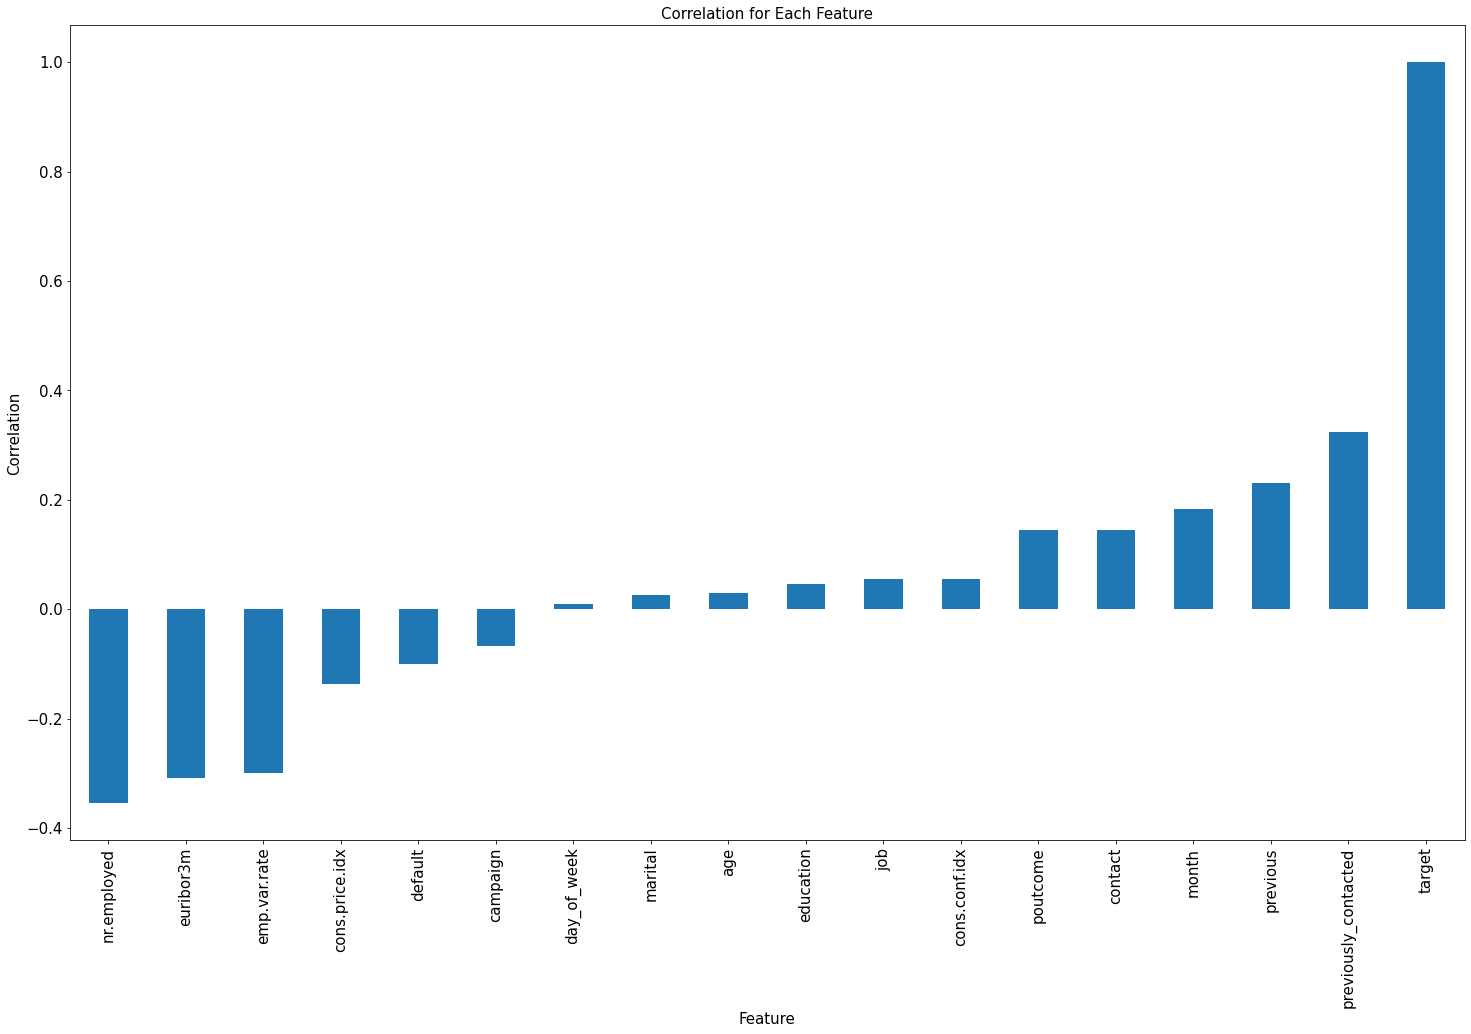

In [62]:
# # Create correlation matrix
std_features_keep = df
corr_matrix = std_features_keep.corr()['target'].sort_values()
threshold = 0.01

for  i, v in corr_matrix.iteritems():
    if(abs(v) < threshold):
      std_features_keep = std_features_keep.drop(i, axis=1)

# Plot for correlation
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
std_plot = (std_features_keep.corr()['target'].sort_values()).plot(kind="bar",figsize=(25,15))
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title('Correlation for Each Feature')
plt.show()

# Metrics

In [96]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [64]:
from sklearn.metrics import confusion_matrix

def get_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  print('% right for no: ', cm[0][0]/(cm[0][0] + cm[0][1]))
  print('% right for yes: ', cm[1][1]/(cm[1][1] + cm[1][0]))
  return cm

def plot_cm(labels, predictions, p=0.5):
  tick_labels = ['Y', 'N']
  cm = get_cm(labels, predictions, p)
  ax = sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

In [65]:
from sklearn.metrics import f1_score

def print_metrics(model, evaluation_results, predictions):
  for name, value in zip(model.metrics_names, evaluation_results):
    print(name, ': ', value)
  print(f'f1 score: {f1_score(y_test, np.round(y_pred.flatten()))}')
  print()

## Neural Network

In [66]:
BATCH_SIZE = 2048


import keras
from keras import backend as K
import tensorflow as tf
from keras import layers

# 0.01, 0.001, or 0.0001
learning_rate_intial = 0.001

def build_model(train_data,learning_rate,output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  network = keras.Sequential()
  # Add a dropout layer for input layer
  network.add(layers.Dropout(0.2, input_shape=(train_data.shape[-1],)))
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=16, activation="relu"))
  # Add a dropout layer for previous hidden layer
  network.add(layers.Dropout(0.5))
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=16, activation="relu"))
  # Add a dropout layer for previous hidden layer
  network.add(layers.Dropout(0.5))
  # Add fully connected layer with a sigmoid activation function
  network.add(layers.Dense(units=1, activation="sigmoid",bias_initializer=output_bias))

  network.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
  )

  return network

# Split Training and Test Data

In [67]:
from sklearn.model_selection import train_test_split

X = std_features_keep.drop(i, axis=1)
y = df['target']

labels = X.columns.values

from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

# Print mean and standard deviation
print("Mean:", round(X[:,0].mean()))
print("Standard deviation:", X[:,0].std())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=RANDOM_SEED)

Mean: 0
Standard deviation: 0.9999999999999998


# Weighted model

In [13]:
no_claim_count, claim_count = np.bincount(df.target)
total_count = len(df.target)

weight_no_claim = ((1 / no_claim_count) * (total_count) / 2.0 )
weight_claim = (((1 / claim_count) * (total_count) / 2.0 )) 
print("no claim:  " + str(weight_no_claim))
print("claim:  " + str(weight_claim))
class_weights = {0: weight_no_claim, 1: weight_claim}

no claim:  0.5634781656999015
claim:  4.438362068965517


In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

initial_bias = np.log([claim/no_claim])
model_weighted = build_model(X_train, learning_rate_intial, initial_bias)

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor="tp", patience=20),
ModelCheckpoint(filepath="best_model.h5", monitor="tp", save_best_only=True)]
history_weighted = model_weighted.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=callbacks,
    shuffle=True,
    class_weight=class_weights
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
20/20 [==============================] - 3s 55ms/step - loss: 1.3467 - tp: 320.0000 - fp: 1013.0000 - tn: 33712.0000 - fn: 4083.0000 - accuracy: 0.8698 - precision: 0.2401 - recall: 0.0727 - auc: 0.5279 - val_loss: 0.3386 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 1822.0000 - val_fn: 237.0000 - val_accuracy: 0.8845 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6909
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 1.0756 - tp: 729.0000 - fp: 2513.0000 - tn: 32212.0000 - fn: 3674.0000 - accuracy: 0.8419 - precision: 0.2249 - recall: 0.1656 - auc: 0.5745 - val_loss: 0.3436 - val_tp: 15.0000 - val_fp: 9.0000 - val_tn: 1814.0000 - val_fn: 222.0000 - val_accuracy: 0.8879 - val_precision: 0.6250 - val_recall: 0.0633 - val_auc: 0.7416
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.9589 - tp: 1034.0000 - fp: 4117.0000 - tn: 30608.0000 - fn: 3369.0000 - accuracy: 0.8087 - precision: 0.2007 - recall: 0.2348 -

Evaluation

loss :  0.44943851232528687
tp :  127.0
fp :  209.0
tn :  1614.0
fn :  110.0
accuracy :  0.8451456427574158
precision :  0.3779761791229248
recall :  0.5358649492263794
auc :  0.7771987318992615
f1 score: 0.4432809773123909

% right for no:  0.8853538123971476
% right for yes:  0.5358649789029536


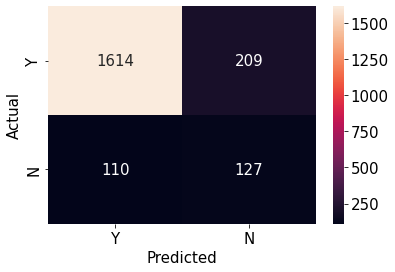

In [15]:
evaluation_results = model_weighted.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_weighted.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model_weighted, evaluation_results, y_pred)
plot_cm(y_test, y_pred)

# Resampling

In [68]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=RANDOM_SEED, sampling_strategy=1.0);
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

No claim Resampled 34725
Claim Resampled 34725
Claim Resampled proportion 50.0%


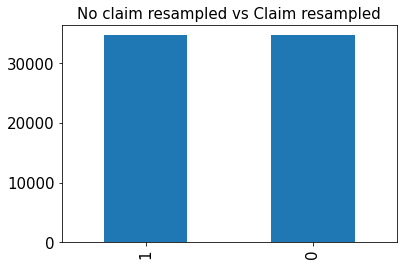

In [69]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

no_claim_resampled, claim_resampled = y_train_resampled.value_counts()
print(f'No claim Resampled {no_claim_resampled}')
print(f'Claim Resampled {claim_resampled}')
print(f'Claim Resampled proportion {round(percentage(claim_resampled, claim_resampled + no_claim_resampled), 2)}%')

y_train_resampled.value_counts().plot(kind="bar", title="No claim resampled vs Claim resampled");

In [70]:
model_resampled = build_model(X_train_resampled, learning_rate_intial)

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor="tp", patience=20),
ModelCheckpoint(filepath="best_model.h5", monitor="tp", save_best_only=True)]
history_weighted = model_resampled.fit(
    X_train_resampled,
    y_train_resampled,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=callbacks,
    shuffle=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
34/34 [==============================] - 3s 33ms/step - loss: 0.8554 - tp: 24671.0000 - fp: 23819.0000 - tn: 10906.0000 - fn: 10054.0000 - accuracy: 0.5123 - precision: 0.5088 - recall: 0.7105 - auc: 0.5431 - val_loss: 0.8817 - val_tp: 217.0000 - val_fp: 1476.0000 - val_tn: 347.0000 - val_fn: 20.0000 - val_accuracy: 0.2738 - val_precision: 0.1282 - val_recall: 0.9156 - val_auc: 0.7207
Epoch 2/100
34/34 [==============================] - 0s 6ms/step - loss: 0.7477 - tp: 26445.0000 - fp: 23018.0000 - tn: 11707.0000 - fn: 8280.0000 - accuracy: 0.5493 - precision: 0.5346 - recall: 0.7616 - auc: 0.5990 - val_loss: 0.7886 - val_tp: 206.0000 - val_fp: 1214.0000 - val_tn: 609.0000 - val_fn: 31.0000 - val_accuracy: 0.3956 - val_precision: 0.1451 - val_recall: 0.8692 - val_auc: 0.7545
Epoch 3/100
34/34 [==============================] - 0s 7ms/step - loss: 0.7002 - tp: 26701.0000 - fp: 20902.0000 - tn: 13823.0000 - fn: 8024.0000 - accuracy: 0.5835 - precision: 0.5609 - recall: 0.7689

loss :  0.5464786291122437
tp :  150.0
fp :  287.0
tn :  1536.0
fn :  87.0
accuracy :  0.8184465765953064
precision :  0.34324944019317627
recall :  0.6329113841056824
auc :  0.788321316242218
f1 score: 0.4451038575667656

% right for no:  0.8425671969281404
% right for yes:  0.6329113924050633


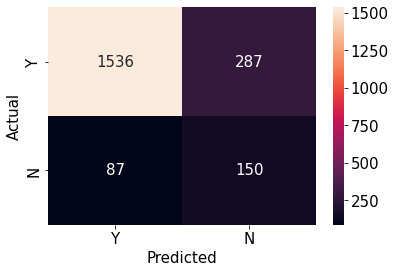

In [71]:
evaluation_results = model_resampled.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_resampled.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model_weighted, evaluation_results, y_pred)
plot_cm(y_test, y_pred)

# Tuning Hyperparamters

In [72]:
!pip install keras-tuner

In [104]:
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras # importing keras

def model_builder(hp):
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  network = keras.Sequential()
  # Add a dropout layer for input layer
  network.add(layers.Dropout(0.2, input_shape=(X_train_resampled.shape[-1],)))
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=hp_units, activation="relu"))
  # Add a dropout layer for previous hidden layer
  network.add(layers.Dropout(0.5))
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=16, activation="relu"))
  # Add a dropout layer for previous hidden layer
  network.add(layers.Dropout(0.5))
  # Add fully connected layer with a sigmoid activation function
  network.add(layers.Dense(units=1, activation="sigmoid"))

  network.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
  )
  return network

tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective=kt.Objective("val_prc", direction="max"), # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory='dir3', # directory to save logs 
project_name='khyperband')

In [105]:
# Perform hypertuning
tuner.search(X_train_resampled, y_train_resampled, epochs=10, validation_data=(X_test, y_test))

Trial 30 Complete [00h 00m 58s]
val_prc: 0.47051888704299927

Best val_prc So Far: 0.4780474305152893
Total elapsed time: 00h 15m 41s
INFO:tensorflow:Oracle triggered exit


In [106]:
# Get the optimal hyperparameters
best_hp=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hp)
# Build the model with the optimal hyperparameters and train it on the data for N epochs

h_history = h_model.fit(X_train_resampled, y_train_resampled, epochs=20, validation_data=(X_test, y_test))

val_auc_per_epoch = h_history.history['val_prc']

best_epoch = val_auc_per_epoch.index(max(val_auc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
1223/1223 [==============================] - 8s 5ms/step - loss: 0.3280 - tp: 589.0000 - fp: 377.0000 - tn: 36171.0000 - fn: 4051.0000 - accuracy: 0.8925 - precision: 0.6097 - recall: 0.1269 - auc: 0.7328 - prc: 0.3363 - val_loss: 0.2889 - val_tp: 47.0000 - val_fp: 15.0000 - val_tn: 1808.0000 - val_fn: 190.0000 - val_accuracy: 0.9005 - val_precision: 0.7581 - val_recall: 0.1983 - val_auc: 0.7746 - val_prc: 0.4704
Epoch 2/20
1223/1223 [==============================] - 5s 4ms/step - loss: 0.3094 - tp: 445.0000 - fp: 247.0000 - tn: 34478.0000 - fn: 3958.0000 - accuracy: 0.8925 - precision: 0.6431 - recall: 0.1011 - auc: 0.7536 - prc: 0.3661 - val_loss: 0.2870 - val_tp: 47.0000 - val_fp: 15.0000 - val_tn: 1808.0000 - val_fn: 190.0000 - val_accuracy: 0.9005 - val_precision: 0.7581 - val_recall: 0.1983 - val_auc: 0.7852 - val_prc: 0.4683
Epoch 3/20
1223/1223 [==============================] - 5s 4ms/step - loss: 0.3043 - tp: 475.0000 - fp: 274.0000 - tn: 34451.0000 - fn: 3928.000

In [107]:
# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel = tuner.hypermodel.build(best_hp)

# Retrain the model
hypermodel.fit(X_train_resampled, y_train_resampled, epochs=best_epoch, validation_data=(X_test, y_test))

Epoch 1/16
1223/1223 [==============================] - 8s 5ms/step - loss: 0.3278 - tp: 463.0000 - fp: 374.0000 - tn: 36174.0000 - fn: 4177.0000 - accuracy: 0.8895 - precision: 0.5532 - recall: 0.0998 - auc: 0.7331 - prc: 0.3243 - val_loss: 0.2885 - val_tp: 44.0000 - val_fp: 13.0000 - val_tn: 1810.0000 - val_fn: 193.0000 - val_accuracy: 0.9000 - val_precision: 0.7719 - val_recall: 0.1857 - val_auc: 0.7792 - val_prc: 0.4609
Epoch 2/16
1223/1223 [==============================] - 5s 4ms/step - loss: 0.3098 - tp: 456.0000 - fp: 258.0000 - tn: 34467.0000 - fn: 3947.0000 - accuracy: 0.8925 - precision: 0.6387 - recall: 0.1036 - auc: 0.7502 - prc: 0.3674 - val_loss: 0.2877 - val_tp: 41.0000 - val_fp: 8.0000 - val_tn: 1815.0000 - val_fn: 196.0000 - val_accuracy: 0.9010 - val_precision: 0.8367 - val_recall: 0.1730 - val_auc: 0.7849 - val_prc: 0.4724
Epoch 3/16
1223/1223 [==============================] - 5s 4ms/step - loss: 0.3033 - tp: 514.0000 - fp: 268.0000 - tn: 34457.0000 - fn: 3889.0000

best epoch:  16
loss :  0.28289926052093506
tp :  52.0
fp :  17.0
tn :  1806.0
fn :  185.0
accuracy :  0.9019417762756348
precision :  0.7536231875419617
recall :  0.2194092869758606
auc :  0.7924827933311462
prc :  0.4738607406616211
f1 score: 0.4451038575667656

% right for no:  0.8425671969281404
% right for yes:  0.6329113924050633


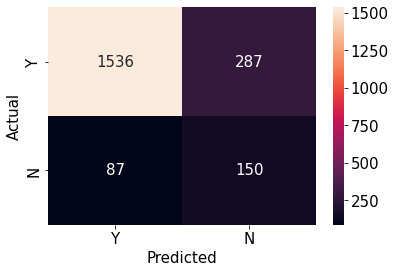

In [108]:
print("best epoch:  " + str(best_epoch))
evaluation_results = h_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_resampled.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(h_model, evaluation_results, y_pred)
plot_cm(y_test, y_pred)

# Architecture

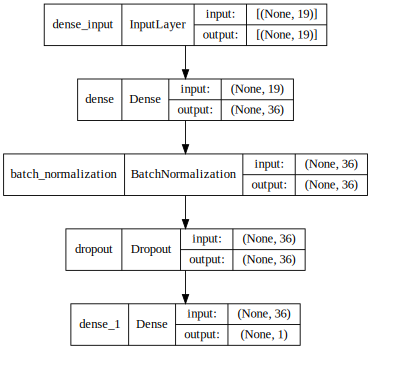

In [ ]:
from IPython.display import SVG
import tensorflow as tf
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_weighted, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))